In [239]:
import os, json
import numpy as np
import pandas as pd
import kagglehub
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 180)

In [148]:
path = kagglehub.dataset_download("computingvictor/transactions-fraud-datasets")
print("Path to dataset files:", path)

transactions_data = pd.read_csv(os.path.join(path, "transactions_data.csv"))
users_data        = pd.read_csv(os.path.join(path, "users_data.csv"))
cards_data        = pd.read_csv(os.path.join(path, "cards_data.csv"))

with open(os.path.join(path, "mcc_codes.json"), "r") as f:
    mcc_dict = json.load(f)

Path to dataset files: /Users/anouksha/.cache/kagglehub/datasets/computingvictor/transactions-fraud-datasets/versions/1


Preprocessing

In [150]:
def parse_money_to_float(s):
    """
    Convert money-like strings to float.
    Handles $, commas, negatives; returns np.nan on failure.
    Examples: "$1,234.56" -> 1234.56 ; "($77.00)" -> -77.0 ; "-$77.00" -> -77.0
    """
    if pd.isna(s): 
        return np.nan
    s = str(s).strip()
    neg = False
    if s.startswith("(") and s.endswith(")"):
        neg = True
        s = s[1:-1]
    s = s.replace("$", "").replace(",", "")
    try:
        val = float(s)
        return -val if neg else val
    except ValueError:
        return np.nan

def to_datetime(series, fmt=None):
    """Coerce to datetime with optional format; never throws."""
    return pd.to_datetime(series, format=fmt, errors="coerce")

def normalize_zip_to_str(series):
    """Convert to 5+ digit ZIP (string). Keeps non-numeric as 'Unknown'."""
    s = series.astype(str)
    # treat 'nan'/'NaT'/'None' as missing
    s = s.where(~s.str.lower().isin({"nan", "nat", "none"}), other=np.nan)
    # strip decimals like '58523.0'
    s = s.str.replace(r"\.0$", "", regex=True)
    # if numeric, pad to at least 5; else mark Unknown
    s_clean = []
    for v in s:
        if pd.isna(v):
            s_clean.append("Unknown")
        else:
            vv = v.strip()
            if vv.isdigit():
                s_clean.append(vv.zfill(5))
            else:
                # keep as-is if it looks like a ZIP+4 (e.g., '10027-1234'), else Unknown
                s_clean.append(vv if "-" in vv and vv.split("-")[0].isdigit() else "Unknown")
    return pd.Series(s_clean, index=series.index, dtype="string")

def to_category(df, cols):
    for c in cols:
        if c in df.columns:
            df[c] = df[c].astype("category")

Transactions data preprocessing

In [152]:
transactions = transactions_data.copy()

In [153]:
transactions.rename(columns={"id":"transaction_id", "client_id":"user_id"}, inplace=True)

In [154]:
# date
transactions["date"] = to_datetime(transactions["date"])

In [155]:
# amount to float
transactions["amount"] = transactions["amount"].apply(parse_money_to_float)

In [156]:
# MCC to 4-digit string (left-padded)
transactions["mcc"] = transactions["mcc"].astype(str).str.replace(r"\.0$", "", regex=True).str.zfill(4)

In [157]:
# clean text-y columns
for col in ["merchant_city", "merchant_state", "use_chip"]:
    if col in transactions.columns:
        transactions[col] = transactions[col].astype("string").fillna("Unknown")

In [158]:
# ZIP normalized to string
if "zip" in transactions.columns:
    transactions["zip"] = normalize_zip_to_str(transactions["zip"])

In [159]:
# errors column as string
if "errors" in transactions.columns:
    transactions["errors"] = transactions["errors"].astype("string")

Users data preprocessing

In [161]:
users = users_data.copy()

In [162]:
if "id" in users.columns and "user_id" not in users.columns:
    users.rename(columns={"id": "user_id"}, inplace=True)

In [163]:
# money-like int columns
for col in ["per_capita_income", "yearly_income", "total_debt"]:
    if col in users.columns:
        users[col] = (
            users[col]
            .astype(str)
            .str.replace(r"[,\$]", "", regex=True)
            .replace({"": np.nan})
            .astype(float)
            .astype("Float64")
        )

In [164]:
if "address" in users.columns:
    users["address"] = users["address"].astype("string")

to_category(users, ["gender"])

Cards data preprocessing

In [166]:
cards = cards_data.copy()

In [167]:
if "id" in cards.columns and "card_id" not in cards.columns:
    cards.rename(columns={"id": "card_id"}, inplace=True)


In [168]:
# card identifier as str
for col in ["card_number", "cvv"]:
    if col in cards.columns:
        cards[col] = cards[col].astype("string")

In [169]:
# categorical fields
to_category(cards, ["card_brand", "card_type", "has_chip", "card_on_dark_web"])

In [170]:
# Dates
if "expires" in cards.columns:
    # If expires is like "03/25"
    cards["expires"] = to_datetime(cards["expires"], fmt="%m/%y").fillna(to_datetime(cards["expires"]))
if "acct_open_date" in cards.columns:
    cards["acct_open_date"] = to_datetime(cards["acct_open_date"])

/var/folders/w8/mq6qy0m57s52db8wzmprr5cw0000gn/T/ipykernel_60097/1382366010.py:23: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  return pd.to_datetime(series, format=fmt, errors="coerce")
/var/folders/w8/mq6qy0m57s52db8wzmprr5cw0000gn/T/ipykernel_60097/1382366010.py:23: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  return pd.to_datetime(series, format=fmt, errors="coerce")


In [171]:
# credit limit to float
if "credit_limit" in cards.columns:
    cards["credit_limit"] = (
        cards["credit_limit"]
        .astype(str)
        .str.replace(r"[,\$]", "", regex=True)
        .replace({"": np.nan})
        .astype(float)
    )

MCC codes

In [173]:
mcc = pd.DataFrame.from_dict(mcc_dict, orient="index", columns=["description"])
mcc.index.name = "mcc"
mcc.reset_index(inplace=True)
mcc["mcc"] = mcc["mcc"].astype(str).str.zfill(4)
mcc.drop_duplicates(subset=["mcc"], inplace=True)
display(mcc.head())

,mcc,description
0,5812,Eating Places and Restaurants
1,5541,Service Stations
2,7996,"Amusement Parks, Carnivals, Circuses"
3,5411,"Grocery Stores, Supermarkets"
4,4784,Tolls and Bridge Fees


 transactions + MCC

In [175]:
tx = transactions.merge(mcc, how="left", on="mcc")
tx

,transaction_id,date,user_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors,description
0,7475327,2010-01-01 00:01:00,1556,2972,-77.00,Swipe Transaction,59935,Beulah,ND,58523,5499,<NA>,Miscellaneous Food Stores
1,7475328,2010-01-01 00:02:00,561,4575,14.57,Swipe Transaction,67570,Bettendorf,IA,52722,5311,<NA>,Department Stores
2,7475329,2010-01-01 00:02:00,1129,102,80.00,Swipe Transaction,27092,Vista,CA,92084,4829,<NA>,Money Transfer
3,7475331,2010-01-01 00:05:00,430,2860,200.00,Swipe Transaction,27092,Crown Point,IN,46307,4829,<NA>,Money Transfer
4,7475332,2010-01-01 00:06:00,848,3915,46.41,Swipe Transaction,13051,Harwood,MD,20776,5813,<NA>,Drinking Places (Alcoholic Beverages)
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13305910,23761868,2019-10-31 23:56:00,1718,2379,1.11,Chip Transaction,86438,West Covina,CA,91792,5499,<NA>,Miscellaneous Food Stores
13305911,23761869,2019-10-31 23:56:00,1766,2066,12.80,Online Transaction,39261,ONLINE,Unknown,Unknown,5815,<NA>,"Digital Goods - Media, Books, Apps"
13305912,23761870,2019-10-31 23:57:00,199,1031,40.44,Swipe Transaction,2925,Allen,TX,75002,4900,<NA>,"Utilities - Electric, Gas, Water, Sanitary"
13305913,23761873,2019-10-31 23:58:00,1986,5443,4.00,Chip Transaction,46284,Daly City,CA,94014,5411,<NA>,"Grocery Stores, Supermarkets"


add users on user_id (left join)

In [177]:
tx_users = tx.merge(users.add_prefix("user_").rename(columns={"user_user_id":"user_id"}),
                    how="left", on="user_id")
tx_users

,transaction_id,date,user_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors,description,user_current_age,user_retirement_age,user_birth_year,user_birth_month,user_gender,user_address,user_latitude,user_longitude,user_per_capita_income,user_yearly_income,user_total_debt,user_credit_score,user_num_credit_cards
0,7475327,2010-01-01 00:01:00,1556,2972,-77.00,Swipe Transaction,59935,Beulah,ND,58523,5499,<NA>,Miscellaneous Food Stores,30,67,1989,7,Female,594 Mountain View Street,46.80,-100.76,23679.0,48277.0,110153.0,740,4
1,7475328,2010-01-01 00:02:00,561,4575,14.57,Swipe Transaction,67570,Bettendorf,IA,52722,5311,<NA>,Department Stores,48,67,1971,6,Male,604 Pine Street,40.80,-91.12,18076.0,36853.0,112139.0,834,5
2,7475329,2010-01-01 00:02:00,1129,102,80.00,Swipe Transaction,27092,Vista,CA,92084,4829,<NA>,Money Transfer,49,65,1970,4,Male,2379 Forest Lane,33.18,-117.29,16894.0,34449.0,36540.0,686,3
3,7475331,2010-01-01 00:05:00,430,2860,200.00,Swipe Transaction,27092,Crown Point,IN,46307,4829,<NA>,Money Transfer,52,67,1967,5,Female,903 Hill Boulevard,41.42,-87.35,26168.0,53350.0,128676.0,685,5
4,7475332,2010-01-01 00:06:00,848,3915,46.41,Swipe Transaction,13051,Harwood,MD,20776,5813,<NA>,Drinking Places (Alcoholic Beverages),51,69,1968,5,Male,166 River Drive,38.86,-76.60,33529.0,68362.0,96182.0,711,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13305910,23761868,2019-10-31 23:56:00,1718,2379,1.11,Chip Transaction,86438,West Covina,CA,91792,5499,<NA>,Miscellaneous Food Stores,81,67,1938,11,Female,766 Third Drive,34.02,-117.89,22681.0,33483.0,196.0,698,5
13305911,23761869,2019-10-31 23:56:00,1766,2066,12.80,Online Transaction,39261,ONLINE,Unknown,Unknown,5815,<NA>,"Digital Goods - Media, Books, Apps",62,66,1957,9,Male,6076 Bayview Boulevard,43.06,-87.96,9995.0,20377.0,12092.0,789,4
13305912,23761870,2019-10-31 23:57:00,199,1031,40.44,Swipe Transaction,2925,Allen,TX,75002,4900,<NA>,"Utilities - Electric, Gas, Water, Sanitary",67,67,1952,4,Female,7927 Plum Lane,33.10,-96.66,32580.0,78329.0,40161.0,720,3
13305913,23761873,2019-10-31 23:58:00,1986,5443,4.00,Chip Transaction,46284,Daly City,CA,94014,5411,<NA>,"Grocery Stores, Supermarkets",44,69,1975,12,Female,5887 Seventh Lane,37.68,-122.43,23752.0,48430.0,62384.0,716,2


 add cards on card_id (left join)

In [179]:
cards_for_merge = cards.copy()
cards_for_merge.rename(columns={"client_id": "card_client_user_id"}, inplace=True)

In [180]:
tx_full = tx_users.merge(
    cards_for_merge.add_prefix("card_").rename(columns={"card_card_id": "card_id"}),
    how="left",
    on="card_id",
    suffixes=("", "_carddup")
)
tx_full

,transaction_id,date,user_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors,description,user_current_age,user_retirement_age,user_birth_year,user_birth_month,user_gender,user_address,user_latitude,user_longitude,user_per_capita_income,user_yearly_income,user_total_debt,user_credit_score,user_num_credit_cards,card_card_client_user_id,card_card_brand,card_card_type,card_card_number,card_expires,card_cvv,card_has_chip,card_num_cards_issued,card_credit_limit,card_acct_open_date,card_year_pin_last_changed,card_card_on_dark_web
0,7475327,2010-01-01 00:01:00,1556,2972,-77.00,Swipe Transaction,59935,Beulah,ND,58523,5499,<NA>,Miscellaneous Food Stores,30,67,1989,7,Female,594 Mountain View Street,46.80,-100.76,23679.0,48277.0,110153.0,740,4,1556,Mastercard,Debit (Prepaid),5497590243197280,2022-07-01,306,YES,2,55.0,2008-05-01,2008,No
1,7475328,2010-01-01 00:02:00,561,4575,14.57,Swipe Transaction,67570,Bettendorf,IA,52722,5311,<NA>,Department Stores,48,67,1971,6,Male,604 Pine Street,40.80,-91.12,18076.0,36853.0,112139.0,834,5,561,Mastercard,Credit,5175842699412235,2024-12-01,438,YES,1,9100.0,2005-09-01,2015,No
2,7475329,2010-01-01 00:02:00,1129,102,80.00,Swipe Transaction,27092,Vista,CA,92084,4829,<NA>,Money Transfer,49,65,1970,4,Male,2379 Forest Lane,33.18,-117.29,16894.0,34449.0,36540.0,686,3,1129,Mastercard,Debit,5874992802287595,2020-05-01,256,YES,1,14802.0,2006-01-01,2008,No
3,7475331,2010-01-01 00:05:00,430,2860,200.00,Swipe Transaction,27092,Crown Point,IN,46307,4829,<NA>,Money Transfer,52,67,1967,5,Female,903 Hill Boulevard,41.42,-87.35,26168.0,53350.0,128676.0,685,5,430,Mastercard,Debit,5346827663529174,2024-10-01,54,NO,2,37634.0,2004-05-01,2006,No
4,7475332,2010-01-01 00:06:00,848,3915,46.41,Swipe Transaction,13051,Harwood,MD,20776,5813,<NA>,Drinking Places (Alcoholic Beverages),51,69,1968,5,Male,166 River Drive,38.86,-76.60,33529.0,68362.0,96182.0,711,2,848,Visa,Debit,4354185735186651,2020-01-01,120,YES,1,19113.0,2009-07-01,2014,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13305910,23761868,2019-10-31 23:56:00,1718,2379,1.11,Chip Transaction,86438,West Covina,CA,91792,5499,<NA>,Miscellaneous Food Stores,81,67,1938,11,Female,766 Third Drive,34.02,-117.89,22681.0,33483.0,196.0,698,5,1718,Mastercard,Debit,5766352389579834,2020-02-01,992,YES,1,26743.0,2019-03-01,2019,No
13305911,23761869,2019-10-31 23:56:00,1766,2066,12.80,Online Transaction,39261,ONLINE,Unknown,Unknown,5815,<NA>,"Digital Goods - Media, Books, Apps",62,66,1957,9,Male,6076 Bayview Boulevard,43.06,-87.96,9995.0,20377.0,12092.0,789,4,1766,Mastercard,Debit,5960254965868032,2024-06-01,91,YES,1,5141.0,2004-03-01,2012,No
13305912,23761870,2019-10-31 23:57:00,199,1031,40.44,Swipe Transaction,2925,Allen,TX,75002,4900,<NA>,"Utilities - Electric, Gas, Water, Sanitary",67,67,1952,4,Female,7927 Plum Lane,33.10,-96.66,32580.0,78329.0,40161.0,720,3,199,Mastercard,Debit,5930100401040067,2021-06-01,908,YES,1,17686.0,2004-02-01,2007,No
13305913,23761873,2019-10-31 23:58:00,1986,5443,4.00,Chip Transaction,46284,Daly City,CA,94014,5411,<NA>,"Grocery Stores, Supermarkets",44,69,1975,12,Female,5887 Seventh Lane,37.68,-122.43,23752.0,48430.0,62384.0,716,2,1986,Visa,Debit,4696464603505748,2021-11-01,762,YES,2,14036.0,2005-11-01,2010,No


In [181]:
core_cols = [
    # transaction core
    "transaction_id", "date", "user_id", "card_id", "amount",
    "use_chip", "merchant_id", "merchant_city", "merchant_state", "zip",
    "mcc", "description", "errors",
    # user features (prefixed with user_)
    "user_current_age", "user_retirement_age", "user_birth_year", "user_birth_month",
    "user_gender", "user_address", "user_latitude", "user_longitude",
    "user_per_capita_income", "user_yearly_income", "user_total_debt",
    "user_credit_score", "user_num_credit_cards",
    # card features (prefixed with card_)
    "card_card_brand", "card_card_type", "card_has_chip", "card_cvv", "card_expires", "card_num_cards_issued",
    "card_credit_limit", "card_acct_open_date", "card_year_pin_last_changed",
    "card_card_on_dark_web"
]

master_df = tx_full[core_cols].copy()
master_df

,transaction_id,date,user_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,description,errors,user_current_age,user_retirement_age,user_birth_year,user_birth_month,user_gender,user_address,user_latitude,user_longitude,user_per_capita_income,user_yearly_income,user_total_debt,user_credit_score,user_num_credit_cards,card_card_brand,card_card_type,card_has_chip,card_cvv,card_expires,card_num_cards_issued,card_credit_limit,card_acct_open_date,card_year_pin_last_changed,card_card_on_dark_web
0,7475327,2010-01-01 00:01:00,1556,2972,-77.00,Swipe Transaction,59935,Beulah,ND,58523,5499,Miscellaneous Food Stores,<NA>,30,67,1989,7,Female,594 Mountain View Street,46.80,-100.76,23679.0,48277.0,110153.0,740,4,Mastercard,Debit (Prepaid),YES,306,2022-07-01,2,55.0,2008-05-01,2008,No
1,7475328,2010-01-01 00:02:00,561,4575,14.57,Swipe Transaction,67570,Bettendorf,IA,52722,5311,Department Stores,<NA>,48,67,1971,6,Male,604 Pine Street,40.80,-91.12,18076.0,36853.0,112139.0,834,5,Mastercard,Credit,YES,438,2024-12-01,1,9100.0,2005-09-01,2015,No
2,7475329,2010-01-01 00:02:00,1129,102,80.00,Swipe Transaction,27092,Vista,CA,92084,4829,Money Transfer,<NA>,49,65,1970,4,Male,2379 Forest Lane,33.18,-117.29,16894.0,34449.0,36540.0,686,3,Mastercard,Debit,YES,256,2020-05-01,1,14802.0,2006-01-01,2008,No
3,7475331,2010-01-01 00:05:00,430,2860,200.00,Swipe Transaction,27092,Crown Point,IN,46307,4829,Money Transfer,<NA>,52,67,1967,5,Female,903 Hill Boulevard,41.42,-87.35,26168.0,53350.0,128676.0,685,5,Mastercard,Debit,NO,54,2024-10-01,2,37634.0,2004-05-01,2006,No
4,7475332,2010-01-01 00:06:00,848,3915,46.41,Swipe Transaction,13051,Harwood,MD,20776,5813,Drinking Places (Alcoholic Beverages),<NA>,51,69,1968,5,Male,166 River Drive,38.86,-76.60,33529.0,68362.0,96182.0,711,2,Visa,Debit,YES,120,2020-01-01,1,19113.0,2009-07-01,2014,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13305910,23761868,2019-10-31 23:56:00,1718,2379,1.11,Chip Transaction,86438,West Covina,CA,91792,5499,Miscellaneous Food Stores,<NA>,81,67,1938,11,Female,766 Third Drive,34.02,-117.89,22681.0,33483.0,196.0,698,5,Mastercard,Debit,YES,992,2020-02-01,1,26743.0,2019-03-01,2019,No
13305911,23761869,2019-10-31 23:56:00,1766,2066,12.80,Online Transaction,39261,ONLINE,Unknown,Unknown,5815,"Digital Goods - Media, Books, Apps",<NA>,62,66,1957,9,Male,6076 Bayview Boulevard,43.06,-87.96,9995.0,20377.0,12092.0,789,4,Mastercard,Debit,YES,91,2024-06-01,1,5141.0,2004-03-01,2012,No
13305912,23761870,2019-10-31 23:57:00,199,1031,40.44,Swipe Transaction,2925,Allen,TX,75002,4900,"Utilities - Electric, Gas, Water, Sanitary",<NA>,67,67,1952,4,Female,7927 Plum Lane,33.10,-96.66,32580.0,78329.0,40161.0,720,3,Mastercard,Debit,YES,908,2021-06-01,1,17686.0,2004-02-01,2007,No
13305913,23761873,2019-10-31 23:58:00,1986,5443,4.00,Chip Transaction,46284,Daly City,CA,94014,5411,"Grocery Stores, Supermarkets",<NA>,44,69,1975,12,Female,5887 Seventh Lane,37.68,-122.43,23752.0,48430.0,62384.0,716,2,Visa,Debit,YES,762,2021-11-01,2,14036.0,2005-11-01,2010,No


In [182]:
master_df.columns

Index(['transaction_id', 'date', 'user_id', 'card_id', 'amount', 'use_chip', 'merchant_id', 'merchant_city', 'merchant_state', 'zip', 'mcc', 'description', 'errors',
       'user_current_age', 'user_retirement_age', 'user_birth_year', 'user_birth_month', 'user_gender', 'user_address', 'user_latitude', 'user_longitude',
       'user_per_capita_income', 'user_yearly_income', 'user_total_debt', 'user_credit_score', 'user_num_credit_cards', 'card_card_brand', 'card_card_type', 'card_has_chip',
       'card_cvv', 'card_expires', 'card_num_cards_issued', 'card_credit_limit', 'card_acct_open_date', 'card_year_pin_last_changed', 'card_card_on_dark_web'],
      dtype='object')

Missing Data

In [184]:
def missing_report(df, sort_by="pct_missing", descending=True):
    rep = (
        df.isna()
          .sum()
          .rename("n_missing")
          .to_frame()
          .assign(
              n_rows=len(df),
              pct_missing=lambda x: (x["n_missing"] / x["n_rows"]).round(4)
          )
          .join(df.dtypes.rename("dtype"))
          .reset_index()
          .rename(columns={"index":"column"})
          .sort_values(sort_by, ascending=not descending, ignore_index=True)
    )
    return rep

report = missing_report(master_df)
print(report.head(25))   # top 25 by % missing
print(f"Total rows: {len(master_df):,}  |  Columns: {master_df.shape[1]}")

                        column  n_missing    n_rows  pct_missing           dtype
0                       errors   13094522  13305915       0.9841  string[python]
1               transaction_id          0  13305915       0.0000           int64
2                user_latitude          0  13305915       0.0000         float64
3       user_per_capita_income          0  13305915       0.0000         Float64
4           user_yearly_income          0  13305915       0.0000         Float64
5              user_total_debt          0  13305915       0.0000         Float64
6            user_credit_score          0  13305915       0.0000           int64
7        user_num_credit_cards          0  13305915       0.0000           int64
8              card_card_brand          0  13305915       0.0000        category
9               card_card_type          0  13305915       0.0000        category
10               card_has_chip          0  13305915       0.0000        category
11                    card_c

In [185]:
df = master_df.drop(columns=["errors"])

Essential Dtype Fixes (Setup Overview)

In [217]:
cat_cols = ["card_card_brand", "card_card_type", "card_has_chip", "use_chip", "merchant_state"]
for c in cat_cols:
    if c in df.columns:
        df[c] = df[c].astype("category")

date_cols = ["date", "card_acct_open_date", "card_expires"]
for c in date_cols:
    if c in df.columns:
        df[c] = pd.to_datetime(df[c], errors="coerce")

num_cols = [
    "amount", "user_latitude", "user_longitude",
    "user_per_capita_income", "user_yearly_income", "user_total_debt",
    "user_credit_score", "user_num_credit_cards",
    "card_num_cards_issued", "card_credit_limit", "card_year_pin_last_changed"
]
for c in num_cols:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")

Hygiene checks


In [242]:
print("Rows/Cols:", df.shape)
print("\nNulls (top 20):\n", df.isna().sum().sort_values(ascending=False).head(20))

# duplicates (conservative: transaction_id should be unique)
if "transaction_id" in df.columns:
    dup_tx = df.duplicated(subset=["transaction_id"]).sum()
    print("Duplicate transaction_id:", dup_tx)

# basic ranges
def check_range(col, low=None, high=None):
    s = df[col].dropna()
    print(f"{col}: min={s.min()}  p1={s.quantile(0.01)}  median={s.median()}  p99={s.quantile(0.99)}  max={s.max()}")

for col in ["amount", "user_yearly_income", "user_total_debt", "user_credit_score", "card_credit_limit"]:
    if col in df.columns: check_range(col)

# time coverage
print("\nDate coverage:", df["date"].min(), "→", df["date"].max())


Rows/Cols: (13305915, 40)

Nulls (top 20):
 transaction_id                0
date                          0
user_total_debt               0
user_credit_score             0
user_num_credit_cards         0
card_card_brand               0
card_card_type                0
card_has_chip                 0
card_cvv                      0
card_expires                  0
card_num_cards_issued         0
card_credit_limit             0
card_acct_open_date           0
card_year_pin_last_changed    0
card_card_on_dark_web         0
weekday                       0
income_tier                   0
score_band                    0
month                         0
user_yearly_income            0
dtype: int64
Duplicate transaction_id: 0
amount: min=-500.0  p1=-96.0  median=28.99  p99=315.95  max=6820.2
user_yearly_income: min=1.0  p1=10869.0  median=41069.0  p99=141161.0  max=280199.0
user_total_debt: min=0.0  p1=0.0  median=51679.0  p99=236393.0  max=461854.0
user_credit_score: min=488  p1=508.0  median=71

Temporal Volume & Spend Overview
###### 2.1 Daily Aggregates (Transactions, Total Spend, Avg Ticket)
###### 2.2 Weekly Aggregates (Smoother Trend: Txn Count, Total Spend, Avg Ticket)
###### 2.3 Weekly Trend Plots (Total Spend & Transaction Count)
###### 2.4 Weekday Seasonality (Txn Count, Total Spend, Average Ticket by Weekday)


Daily head:
             txn_count  total_spend  avg_ticket
date                                          
2010-01-01       3463    124498.32   35.951002
2010-01-02       2989    138700.62   46.403687
2010-01-03       3311    135016.77   40.778245
2010-01-04       3244    131315.75   40.479578
2010-01-05       3330    143760.66   43.171369


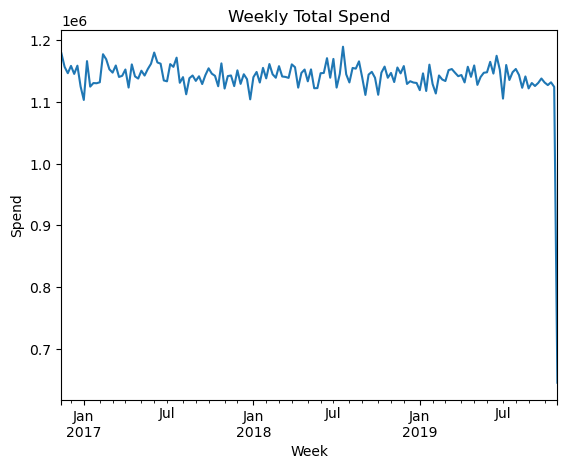

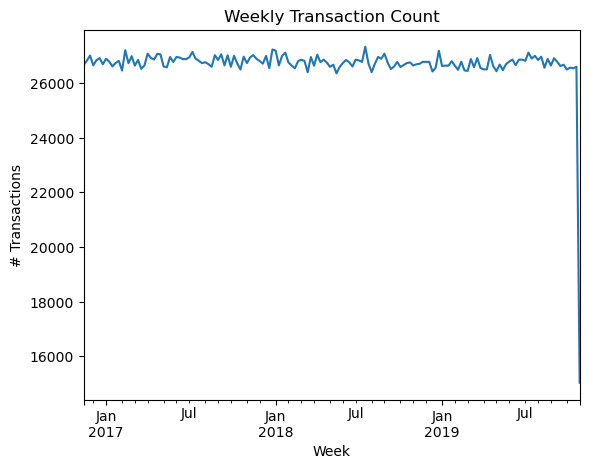


Weekday patterns:
          txn_count  total_spend  avg_ticket
weekday                                    
0          1896914  81553299.10   42.992618
1          1897678  81712123.90   43.059004
2          1895871  80900569.12   42.671980
3          1918666  82146186.92   42.814219
4          1895372  81677869.69   43.093319
5          1902370  81766751.16   42.981518
6          1899044  82078722.39   43.221075


In [221]:
# daily
daily = df.groupby(pd.Grouper(key="date", freq="D")).agg(txn_count=("transaction_id","count"), total_spend=("amount","sum"))
daily["avg_ticket"] = daily["total_spend"] / daily["txn_count"]
print("\nDaily head:\n", daily.head())

# weekly (smoother)
weekly = df.groupby(pd.Grouper(key="date", freq="W")).agg(txn_count=("transaction_id","count"), total_spend=("amount","sum"))
weekly["avg_ticket"] = weekly["total_spend"] / weekly["txn_count"]

# plot (sampled index to lighten)
weekly_plot = weekly.tail(156)  # last 3 years if available
plt.figure()
weekly_plot["total_spend"].plot(title="Weekly Total Spend")
plt.xlabel("Week"); plt.ylabel("Spend")
plt.show()

plt.figure()
weekly_plot["txn_count"].plot(title="Weekly Transaction Count")
plt.xlabel("Week"); plt.ylabel("# Transactions")
plt.show()

# weekday seasonality
df["weekday"] = df["date"].dt.weekday
wd = df.groupby("weekday").agg(txn_count=("transaction_id","count"), total_spend=("amount","sum"))
wd["avg_ticket"] = wd["total_spend"]/wd["txn_count"]
print("\nWeekday patterns:\n", wd)

Segment-level TS (Phase-1 baseline prep)
Example segments: income tier & credit score band

/var/folders/w8/mq6qy0m57s52db8wzmprr5cw0000gn/T/ipykernel_60097/203085487.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  seg = df.groupby(["month","income_tier"]).agg(total_spend=("amount","sum"), txn_count=("transaction_id","count")).reset_index()



Segment (income tier) monthly spend head:
 income_tier       High         Low         Mid
month                                         
2010-01-01   458173.38  1774991.19  2139367.55
2010-02-01   434624.16  1658629.65  2009916.43
2010-03-01   489558.95  1837443.96  2212850.47
2010-04-01   474998.96  1775375.28  2157577.09
2010-05-01   488446.34  1870518.47  2251636.99


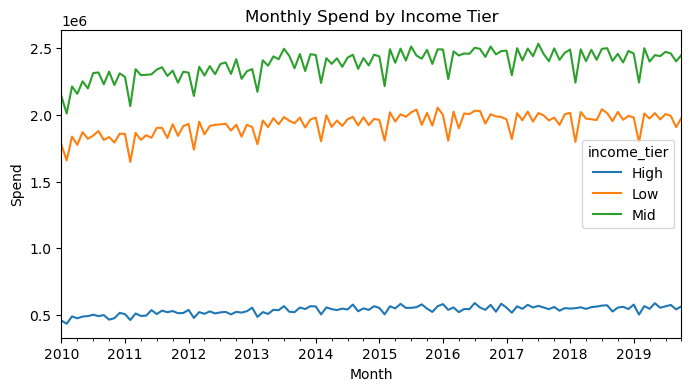

In [223]:
def income_tier(y):
    if pd.isna(y): return np.nan
    if y < 40000: return "Low"
    if y < 80000: return "Mid"
    return "High"

def score_band(s):
    if pd.isna(s): return np.nan
    if s < 580: return "Poor"
    if s < 670: return "Fair"
    if s < 740: return "Good"
    if s < 800: return "VeryGood"
    return "Excellent"

df["income_tier"] = df["user_yearly_income"].apply(income_tier).astype("category")
df["score_band"] = df["user_credit_score"].apply(score_band).astype("category")
df["month"] = df["date"].dt.to_period("M").dt.to_timestamp()

seg = df.groupby(["month","income_tier"]).agg(total_spend=("amount","sum"), txn_count=("transaction_id","count")).reset_index()
pivot_spend = seg.pivot(index="month", columns="income_tier", values="total_spend")
print("\nSegment (income tier) monthly spend head:\n", pivot_spend.head())

# quick plot
pivot_spend.plot(title="Monthly Spend by Income Tier", figsize=(8,4))
plt.xlabel("Month"); plt.ylabel("Spend")
plt.show()

RFM-style user profiling (monthly)


In [225]:
monthly_user = df.groupby(["user_id","month"]).agg(
    total_spend=("amount","sum"),
    txn_count=("transaction_id","count"),
    avg_ticket=("amount","mean")
).reset_index()

# Recency (relative to global max month)
max_month = monthly_user["month"].max()
rfm = monthly_user.groupby("user_id").agg(
    last_month=("month","max"),
    freq_months=("month","nunique"),
    total_spend_all=("total_spend","sum")
).reset_index()
rfm["recency_months"] = (max_month.to_period("M") - rfm["last_month"].dt.to_period("M")).apply(lambda x: x.n)

print("\nRFM head:\n", rfm.head())


RFM head:
    user_id last_month  freq_months  total_spend_all  recency_months
0        0 2019-10-01          118        625799.67               0
1        1 2019-10-01          118        336187.37               0
2        2 2019-10-01          118        291534.27               0
3        3 2019-10-01          118        280685.46               0
4        4 2019-10-01          118        595722.36               0


Credit stress / utilization proxies
DTI at user-level (static proxy from snapshot cols)

In [227]:

if {"user_total_debt","user_yearly_income"}.issubset(df.columns):
    dti = df.groupby("user_id")[["user_total_debt","user_yearly_income"]].first().reset_index()
    dti["DTI"] = dti["user_total_debt"] / dti["user_yearly_income"].replace(0, np.nan)
    print("\nDTI summary:\n", dti["DTI"].describe())

# Utilization proxy (monthly spend / credit_limit) – not true utilization but a useful signal
if "card_credit_limit" in df.columns:
    # If multiple cards per user, take max limit per user_id each month
    month_user_limit = df.groupby(["user_id","month"])["card_credit_limit"].max()
    util = monthly_user.set_index(["user_id","month"])[["total_spend"]].join(month_user_limit)
    util["util_proxy"] = util["total_spend"] / util["card_credit_limit"].replace(0, np.nan)
    util_reset = util.reset_index()
    print("\nUtilization proxy summary (monthly):\n", util_reset["util_proxy"].describe())

# Rolling z-scores per user to spot spikes/drops (stress/income shift candidates)
monthly_user = monthly_user.sort_values(["user_id","month"])
monthly_user["roll_mean"] = monthly_user.groupby("user_id")["total_spend"].transform(lambda s: s.rolling(6, min_periods=3).mean())
monthly_user["roll_std"]  = monthly_user.groupby("user_id")["total_spend"].transform(lambda s: s.rolling(6, min_periods=3).std())
monthly_user["z_spend"]   = (monthly_user["total_spend"] - monthly_user["roll_mean"]) / monthly_user["roll_std"]

print("\nExtreme monthly z-spend events (|z|>=3):")
print(monthly_user.loc[monthly_user["z_spend"].abs()>=3, ["user_id","month","total_spend","z_spend"]].head(10))


DTI summary:
 count      1219.0
mean     1.274375
std      0.883591
min           0.0
25%      0.494084
50%      1.313484
75%      1.897865
max      4.678159
Name: DTI, dtype: Float64

Utilization proxy summary (monthly):
 count    139084.000000
mean          1.547514
std          25.657126
min          -0.003128
25%           0.130373
50%           0.200001
75%           0.319756
max        1750.840000
Name: util_proxy, dtype: float64

Extreme monthly z-spend events (|z|>=3):
Empty DataFrame
Columns: [user_id, month, total_spend, z_spend]
Index: []


Card & channel behavior

In [229]:



if {"use_chip","card_card_brand","card_card_type"}.issubset(df.columns):
    chip_rate = df.groupby(["month","card_card_brand","card_card_type"]).agg(
        chip_share=("use_chip", lambda s: (s.astype(str).str.lower().isin(["y","yes","true","1"]).mean())),
        txn=("transaction_id","count")
    ).reset_index()
    print("\nChip share by brand/type (head):\n", chip_rate.head())

# Tenure vs spend
if "card_acct_open_date" in df.columns:
    df["tenure_days"] = (df["date"] - df["card_acct_open_date"]).dt.days
    ten = df[df["tenure_days"].notna()]
    ten_grp = ten.groupby(pd.cut(ten["tenure_days"], bins=[-1,30,180,365,730,99999])).agg(
        avg_spend=("amount","mean"), txn=("transaction_id","count")
    )
    print("\nSpend vs card tenure (binned days):\n", ten_grp)


/var/folders/w8/mq6qy0m57s52db8wzmprr5cw0000gn/T/ipykernel_60097/3716965338.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  chip_rate = df.groupby(["month","card_card_brand","card_card_type"]).agg(



Chip share by brand/type (head):
        month card_card_brand   card_card_type  chip_share   txn
0 2010-01-01            Amex           Credit         0.0  7075
1 2010-01-01            Amex            Debit         NaN     0
2 2010-01-01            Amex  Debit (Prepaid)         NaN     0
3 2010-01-01        Discover           Credit         0.0  2642
4 2010-01-01        Discover            Debit         NaN     0

Spend vs card tenure (binned days):
               avg_spend       txn
tenure_days                      
(-1, 30]      42.921897     61279
(30, 180]     43.198302    307567
(180, 365]    43.025218    404620
(365, 730]    43.160379    877143
(730, 99999]  42.940039  11654997


/var/folders/w8/mq6qy0m57s52db8wzmprr5cw0000gn/T/ipykernel_60097/3716965338.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ten_grp = ten.groupby(pd.cut(ten["tenure_days"], bins=[-1,30,180,365,730,99999])).agg(


Geography (merchant_state)

In [230]:

if "merchant_state" in df.columns:
    top_states = df["merchant_state"].value_counts().head(15)
    print("\nTop merchant states by txn count:\n", top_states)

    state_spend = df.groupby("merchant_state")["amount"].sum().sort_values(ascending=False).head(15)
    print("\nTop merchant states by spend:\n", state_spend)


Top merchant states by txn count:
 merchant_state
Unknown    1563700
CA         1427087
TX         1010207
NY          857510
FL          701623
OH          484122
IL          467931
NC          429427
PA          417766
MI          397970
GA          368206
NJ          322227
IN          312470
WA          286525
TN          284709
Name: count, dtype: int64

Top merchant states by spend:
 merchant_state
Unknown    88896665.09
CA         59084616.19
TX         42477208.43
NY         39721647.77
FL         28603402.23
IL         19500277.78
PA         18234988.56
NC         16790704.15
OH         16225273.04
MI         15051464.03
NJ         14904752.92
GA         13617942.73
TN         12717884.02
VA         12113811.78
IN         11282055.46
Name: amount, dtype: float64


/var/folders/w8/mq6qy0m57s52db8wzmprr5cw0000gn/T/ipykernel_60097/2134554357.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  state_spend = df.groupby("merchant_state")["amount"].sum().sort_values(ascending=False).head(15)


Leakage checks (illustrative)

In [233]:

leak_candidates = ["card_expires", "card_year_pin_last_changed"]
present_leaks = [c for c in leak_candidates if c in df.columns]
print("\nPotential leakage columns present:", present_leaks)
# For modeling, ensure any value used is <= transaction date (or drop).

# --- 9) Sequence table for LSTM (Phase-2 sketch)
# monthly_user already has the core signals; join static segments
seq = monthly_user.merge(
    df[["user_id","income_tier","score_band"]].drop_duplicates("user_id"),
    on="user_id", how="left"
)



Potential leakage columns present: ['card_expires', 'card_year_pin_last_changed']


join utilization proxy

In [235]:

if "util_proxy" in util_reset.columns:
    seq = seq.merge(util_reset[["user_id","month","util_proxy"]], on=["user_id","month"], how="left")

print("\nSequence table columns:", seq.columns.tolist()[:20], " ...")
print("Sequence length stats (points per user):\n", seq.groupby("user_id")["month"].nunique().describe())



Sequence table columns: ['user_id', 'month', 'total_spend', 'txn_count', 'avg_ticket', 'roll_mean', 'roll_std', 'z_spend', 'income_tier', 'score_band', 'util_proxy']  ...
Sequence length stats (points per user):
 count    1219.000000
mean      114.328958
std        13.074847
min        22.000000
25%       118.000000
50%       118.000000
75%       118.000000
max       118.000000
Name: month, dtype: float64
